# ohsome API: Some general examples on how to use the API with Python
### Import Python packages

In [1]:
# pandas for working with table structured data
import pandas as pd

# json for handling with json responses
import json

# requests for http get/post requests
import requests

# csv for writing and loading csv files
import csv

# plotly for generating interactive graphs
import plotly.plotly as py
import plotly.graph_objs as go

from IPython.display import *

### Get metadata of the underlying OSM full-history data extract
First let's request some metadata and have a look which areas are available via the ohsome API 

In [1]:
ohsome_api = "https://api.ohsome.org/v0.9-dev"
metadata = requests.get(ohsome_api+"/metadata").json()

display(metadata)

{'apiVersion': '0.9',
 'attribution': {'text': '© OpenStreetMap contributors',
  'url': 'https://ohsome.org/copyrights'},
 'extractRegion': {'spatialExtent': {'coordinates': [[[-180.0, -90.0],
     [180.0, -90.0],
     [180.0, 90.0],
     [-180.0, 90.0],
     [-180.0, -90.0]]],
   'type': 'Polygon'},
  'temporalExtent': {'fromTimestamp': '2007-01-01',
   'toTimestamp': '2019-02-19T23:00:00'}}}

<span style="color:darkred">Ohsome</span> you have access to the OSM history on a global scale :). Lossless information on the historical evolution of OSM is available from 2007, January to 2019, February. This means that all properties of the original OSM data are maintained.

### Define areas of interest and time interval

Now let's get started and have a more detailed look at three areas in Germany: Heidelberg _(hd)_, Mannheim _(ma)_ and Ludwigsburg _(lu)_. We define define the bounding boxes and time intervals we are interested in.

In [1]:
# http://norbertrenner.de/osm/bbox.html
bbox = { 
    "hd" : "8.6581,49.3836,8.7225,49.4363",
    "ma" : "8.4514,49.4589,8.5158,49.5114",
    "lu" :" 8.3936,49.4448,8.4579,49.4974"}

# https://en.wikipedia.org/wiki/ISO_8601
time_monthly = "2007-11-01/2018-11-01/P1M"

Now we are ready to go. Our Swagger documentation provides you with the needed information to fire some requests against our <span style="color:darkred">ohsome</span> API. In the following we show you some examples how to grap information you are intereted in using Python. 

## Aggregation endpoint
Let's start with the aggregation endpoint which allows you to retrive aggregated stats for the OSM history data. You can filter by any OSM tag you are interested in _(keys)_, define your area of interest _(bboxes)_ and any time interval _(time)_.

### Count highways in the Heidelberg area over time

In [1]:
params = {'bboxes': bbox['hd'],
          'keys': 'highway',
          'time': time_monthly,
          'showMetadata': 'true'}

res = requests.get(ohsome_api+"/elements/count", params)

display(HTML('<h4>ohsome API request</h4>'))
display(res.url)

display(HTML('<h4>API response</h4>'))
df = pd.DataFrame(res.json()['result'])
display(df.head(10))

'https://api.ohsome.org/v0.9-dev/elements/count?bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&keys=highway&time=2007-11-01%2F2018-11-01%2FP1M&showMetadata=true'

,timestamp,value
0,2007-11-01T00:00:00Z,187.0
1,2007-12-01T00:00:00Z,275.0
2,2008-01-01T00:00:00Z,295.0
3,2008-02-01T00:00:00Z,295.0
4,2008-03-01T00:00:00Z,326.0
5,2008-04-01T00:00:00Z,327.0
6,2008-05-01T00:00:00Z,351.0
7,2008-06-01T00:00:00Z,570.0
8,2008-07-01T00:00:00Z,1157.0
9,2008-08-01T00:00:00Z,1692.0


This is how the result looks like - you get the number of highways at each time interval (only ten time stamps are shown here). Let's plot it!  

In [1]:
data = [go.Bar(x=df.timestamp, y=df.value)]

fig = dict(data=data, layout=go.Layout(title="Count of OSM highways within Heidelberg"))
py.iplot(fig, filename='count')

### Ratio between two OSM tag groups over time
The <span style="color:darkred">ohsome</span> API also allows you two generate ratios between two different OSM tag groups. In this example we answer the question: What is the percentage of OSM highways that have informtion on speed limits (i.e., tagged with the OSM key maxspeed)? 

In [1]:
params = {'bboxes': bbox['hd'],
          'keys': 'highway',
          'keys2': 'highway,maxspeed',
          'time': time_monthly,
          'types': 'way', 
          'types2': 'way',
          'showMetadata': 'true'}

res = requests.get(ohsome_api+"/elements/count/ratio", params)

display(HTML('<h4>ohsome API request</h4> </span>'))
display(res.url)

display(HTML('<h4>API response</h4>'))
df = pd.DataFrame(res.json()['ratioResult'])
display(df.head(10))

'https://api.ohsome.org/v0.9-dev/elements/count/ratio?bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&keys=highway&keys2=highway%2Cmaxspeed&time=2007-11-01%2F2018-11-01%2FP1M&types=way&types2=way&showMetadata=true'

,ratio,timestamp,value,value2
0,0.000000,2007-11-01T00:00:00Z,181.0,0.0
1,0.000000,2007-12-01T00:00:00Z,267.0,0.0
2,0.000000,2008-01-01T00:00:00Z,287.0,0.0
3,0.000000,2008-02-01T00:00:00Z,287.0,0.0
4,0.000000,2008-03-01T00:00:00Z,314.0,0.0
5,0.000000,2008-04-01T00:00:00Z,315.0,0.0
6,0.000000,2008-05-01T00:00:00Z,339.0,0.0
7,0.022814,2008-06-01T00:00:00Z,526.0,12.0
8,0.067260,2008-07-01T00:00:00Z,1011.0,68.0
9,0.062246,2008-08-01T00:00:00Z,1478.0,92.0


And again let's visualize the result in a graph: 

In [1]:
hwy = go.Scatter(
    x = df.timestamp,
    y = df.value,
    name = "highway"
)

hwy_maxspeed = go.Scatter(
    x = df.timestamp,
    y = df.value2,
    name = "highway,maxspeed"
)

ratio = go.Scatter(
    x = df.timestamp,
    y = df.ratio,
    yaxis='y2',
    name = "ratio"
)

data = [hwy, hwy_maxspeed, ratio]

layout = go.Layout(
    title='Ratio between OSM highways and OSM highways with maxspeed',
    yaxis2 = dict(
        side = 'right',
        overlaying = 'y',
        showgrid = False
    ),
    legend = dict(
        orientation = "h")      
)

fig = go.Figure(data, layout)
py.iplot(fig, filename='ratio')

### Count over time grouped by bounding box
We are not only interested in the Heidelberg area but also in Mannheim and Ludwigshaven. Using the _groupBy_ funtionalities allows you to get the OSM evolution in all areas with one single request.

In [1]:
bboxes = '|'.join("{}:{}".format(k,v) for (k,v) in bbox.items())

params = {'bboxes': bboxes,
          'keys': 'highway',
          'time': time_monthly,
          'types': 'way', 
         }

res = requests.get(ohsome_api+"/elements/count/groupBy/boundary", params)

display(HTML('<h4>ohsome API request</h4>'))
display(res.url)

df = pd.DataFrame(res.json()['groupByResult'])

display(HTML('<h4>API response</h4>'))
display(df.head(10))

display(HTML('<h4>API response: result for hd</h4>'))
display(pd.DataFrame(df.result[0]).head(10))

'https://api.ohsome.org/v0.9-dev/elements/count/groupBy/boundary?bboxes=hd%3A8.6581%2C49.3836%2C8.7225%2C49.4363%7Cma%3A8.4514%2C49.4589%2C8.5158%2C49.5114%7Clu%3A+8.3936%2C49.4448%2C8.4579%2C49.4974&keys=highway&time=2007-11-01%2F2018-11-01%2FP1M&types=way'

,groupByObject,result
0,hd,"[{'timestamp': '2007-11-01T00:00:00Z', 'value'..."
1,ma,"[{'timestamp': '2007-11-01T00:00:00Z', 'value'..."
2,lu,"[{'timestamp': '2007-11-01T00:00:00Z', 'value'..."


,timestamp,value
0,2007-11-01T00:00:00Z,181.0
1,2007-12-01T00:00:00Z,267.0
2,2008-01-01T00:00:00Z,287.0
3,2008-02-01T00:00:00Z,287.0
4,2008-03-01T00:00:00Z,314.0
5,2008-04-01T00:00:00Z,315.0
6,2008-05-01T00:00:00Z,339.0
7,2008-06-01T00:00:00Z,526.0
8,2008-07-01T00:00:00Z,1011.0
9,2008-08-01T00:00:00Z,1478.0


Are you curious how the result looks like?

In [1]:
result1=pd.DataFrame(df.result[0])
trace1 = go.Bar(
    x=result1.timestamp,
    y=result1.value,
    name=df.groupByObject[0]
)

result2=pd.DataFrame(df.result[1])
trace2 = go.Bar(
    x=result2.timestamp,
    y=result2.value,
    name=df.groupByObject[1]
)

result3=pd.DataFrame(df.result[2])
trace3 = go.Bar(
    x=result3.timestamp,
    y=result3.value,
    name=df.groupByObject[2]
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title='Number of OSM highways in Heidelberg, Mannheim and Ludwigshafen',
    barmode='group',
    legend = dict(
        orientation = "h")
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='groupBy')

## data extraction endpoint
### snapshot data over time
json response looks like:
```javascript
{
 'type': 'FeatureCollection',
 'features': [
     {
         'type': 'Feature',
         'geometry': {
             'type': 'Point',
              'coordinates': [8.670155212077008, 49.399659869507616]},
         'properties': {
             '@osmId': 'way/135548604',
             '@snapshotTimestamp': '2019-02-19T23:00:00',
              // filter conditions are always present in the result
             'highway': 'living_street',
             
             // >>> only with properties contains 'metadata'
             '@changesetId': 39952663,
             '@lastEdit': '2016-06-11T13:27:58',
             '@osmType': 'WAY',
             '@version': 7,
             // <<<
            
             // >>> only with properties contains 'tags'
             'lit': 'yes',
             'name': 'Montpellierstraße',
             'smoothness': 'excellent',
             'surface': 'asphalt'
             // <<<
         }},
      {
          'type': 'Feature',
          'geometry': {
               'type': 'Point',
               'coordinates': [8.66844507130631, 49.400558346827175]},
          'properties': {
              '@osmId': 'way/135548612',
              '@snapshotTimestamp': '2019-02-19T23:00:00',
              'highway': 'living_street',
              '@changesetId': 39952663,
              '@osmType': 'WAY',
              '@lastEdit': '2016-06-11T13:27:55',
              '@version': 8,
              'lit': 'yes',
              //....
       },
       //....
  ]
}
```

In [1]:
params = {'bboxes': bbox['hd'],
          'properties' : 'tags,metadata',
          'types': 'way,node,relation', 
          'keys' : 'highway'
         }

res = requests.get(ohsome_api+"/elements/centroid", params)
body = res.json()

In [1]:
def dataExtraction():
    with open('./dataExtraction.csv',mode='w') as csv_file:
        csv_file = csv.writer(csv_file,delimiter=',',quotechar='"',quoting=csv.QUOTE_NONNUMERIC)
        csv_file.writerow(['timestamp','osmid','version','osmtype','tagkey','tagvalue'])
        
        for f in body['features']:
            tags = f['properties']
            osmid = tags['@osmId']
            timestamp = tags['@lastEdit']
            version = tags['@version']
            osmtype = tags['@osmType']
            for k,v in tags.items():
                if not k.startswith('@'):
                    try:
                        csv_file.writerow([timestamp,osmid,version,osmtype,k,v])
                    except:
                        continue
    return pd.read_csv("./dataExtraction.csv", parse_dates=['timestamp'], encoding="iso-8859-1")
de = dataExtraction()
display(de.head(10))


,timestamp,osmid,version,osmtype,tagkey,tagvalue
0,2018-02-08 07:31:22,way/4420813,26,WAY,highway,residential
1,2018-02-08 07:31:22,way/4420813,26,WAY,lit,yes
2,2018-02-08 07:31:22,way/4420813,26,WAY,maxspeed,30
3,2018-02-08 07:31:22,way/4420813,26,WAY,name,Panoramastraße
4,2018-02-08 07:31:22,way/4420813,26,WAY,sidewalk,both
5,2018-02-08 07:31:22,way/4420813,26,WAY,smoothness,good
6,2018-02-08 07:31:22,way/4420813,26,WAY,source:maxspeed,DE:zone:30
7,2018-02-08 07:31:22,way/4420813,26,WAY,surface,asphalt
8,2016-08-21 06:07:33,way/9349925,19,WAY,highway,tertiary
9,2016-08-21 06:07:33,way/9349925,19,WAY,lanes,1


### latest timestamp

In [1]:
def latestTimetamp():
    display(de.timestamp.max())
latestTimetamp()

Timestamp('2019-02-14 05:20:54')

### mean number of versions

In [1]:
def meanVersions():
    series_gb = de.groupby(['osmid']).mean().version
    display(series_gb.head(10))
    display(series_gb.mean())
meanVersions()

osmid
node/1019329416     6
node/107479229     16
node/1089213422     4
node/1119794531     6
node/11244623       6
node/11247599       5
node/11247600       5
node/1125158222     4
node/1125158381     4
node/1125556796     4
Name: version, dtype: int64

3.621616856210879

In [1]:
def meanTags():
    dfgb = de.groupby(['osmid','version']).size().reset_index(name="tags")
    display(df_gb.tags.mean())
meanTags()

,osmid,version,tags
0,node/1019329416,6,4
1,node/107479229,16,7
2,node/1089213422,4,3
3,node/1119794531,6,3
4,node/11244623,6,2


3.7582650092568102

### ratio between different osm types

In [1]:
def ratioTypes():
    df_gb = de.groupby(['osmid','osmtype']).size().reset_index(name='tmp')
    df_gb = df_gb.groupby(['osmtype']).agg({'osmid':'count'})
    display(df_gb.head())
    #dfgb.plot.pie(y='osmid')
    trace = go.Pie(values=df_gb.osmid)
    py.iplot([trace], filename='basic_pie_chart')
ratioTypes()


,osmid
osmtype,
NODE,3256
RELATION,12
WAY,8075


### data extraction with full history between a time interval
json response looks like this:
```javascript
{
 'type': 'FeatureCollection',
 'features': [
     {
        'type': 'Feature',
        'geometry': {'type': 'Point', 'coordinates': [8.67003845, 49.39963365]},
         'properties': {
             '@osmId': 'way/135548604',
             '@validFrom': '2011-11-01T15:59:26',
             '@validTo': '2012-03-17T19:50:16',
             'highway': 'construction'
             // >>> only with properties contains 'metadata'
             '@changesetId': 9713765,
             '@osmType': 'WAY',   
             '@version': 1,
             // <<<
    }},
    {
        'type': 'Feature',
        'geometry': {'type': 'Point', 'coordinates': [8.67003845, 49.39963365]},
        'properties': {
            '@osmId': 'way/135548604',
            '@validFrom': '2012-03-17T19:50:16',
            '@validTo': '2013-03-19T18:32:14',
            'highway': 'residential'
            '@changesetId': 11011888,
            '@osmType': 'WAY',
            '@version': 2,
            // ...
    }},
  // ...
  ]
}
```

In [1]:
def dataExtractionFullHistory():
    keys="highway"
    
    temporalExtent = METADATA['extractRegion']['temporalExtent']
    fromTimestamp = pd.to_datetime(temporalExtent['fromTimestamp'])
    toTimestamp = pd.to_datetime(temporalExtent['toTimestamp'])
    time= ','.join(temporalExtent.values())
    
    res = dataFullHistory("/centroid"
            ,keys=keys,values=None
            ,bboxes=BBOX['hd'],time=time
            ,properties='metadata'
            ,types="way,node,relation")
    
    display(res.url)   
    
    body = res.json()
    features = body['features']
    
    with open('./dataExtractionFullHistory.csv',mode='w') as csv_file:
        csv_file = csv.writer(csv_file,delimiter=',',quotechar='"',quoting=csv.QUOTE_NONNUMERIC)
        csv_file.writerow(['timestamp','osmid','type','mod','shifted', 'dlon','dlat'])
        last = features[0]
        lastP = last['properties']
        lastG = last['geometry']['coordinates']
        csv_file.writerow([lastP['@validFrom'],lastP['@osmId'],lastP['@osmType'],'c',0,0.0,0.0])    
        for f in features[1:]:
            fP = f['properties']
            
            fG = f['geometry']['coordinates']
            if lastP['@osmId'] == fP['@osmId']:
                if lastP['@validTo'] == fP['@validFrom']:
                    deltas = [p - c for p,c in zip(lastG,fG)]
                    shifted = not all(d == 0 for d in deltas)
                    csv_file.writerow([fP['@validFrom'],fP['@osmId'],fP['@osmType'],'u',int(shifted),deltas[0],deltas[1]])
                else:
                    csv_file.writerow([lastP['@validTo'],lastP['@osmId'],lastP['@osmType'],'d',0,0.0,0.0])
                    csv_file.writerow([fP['@validFrom'],fP['@osmId'],fP['@osmType'],'c',0,0.0,0.0])
            else:
                # transform to real datetime for comparison
                lastValidTo = pd.to_datetime(lastP['@validTo'])
                if lastValidTo  != toTimestamp:
                    csv_file.writerow([lastP['@validTo'],lastP['@osmId'],lastP['@osmType'],'d',0,0.0,0.0])
                csv_file.writerow([fP['@validFrom'],fP['@osmId'],fP['@osmType'],'c',0,0.0,0.0])
                
            lastP = fP
            lastG = fG
    return pd.read_csv("./dataExtractionFullHistory.csv",dtype={'shifted':'bool','dlon':'float32','dlat':'float32'}, parse_dates=['timestamp'])
deh = dataExtractionFullHistory()

'https://api.ohsome.org/v0.9-dev/elementsFullHistory/centroid?keys=highway&bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&time=2007-01-01%2C2019-02-19T23%3A00%3A00&properties=metadata&types=way%2Cnode%2Crelation'

In [1]:
deh.head()

,timestamp,osmid,type,mod,shifted,dlon,dlat
0,2011-11-01 15:59:26,way/135548604,WAY,c,False,0.000000e+00,0.000000e+00
1,2012-03-17 19:50:16,way/135548604,WAY,u,False,0.000000e+00,0.000000e+00
2,2013-03-19 18:32:14,way/135548604,WAY,u,True,-5.435000e-05,1.955000e-05
3,2013-05-31 22:35:50,way/135548604,WAY,u,True,-5.370000e-05,-3.785000e-05
4,2013-08-27 01:24:11,way/135548604,WAY,u,True,5.297510e-09,-6.897913e-09


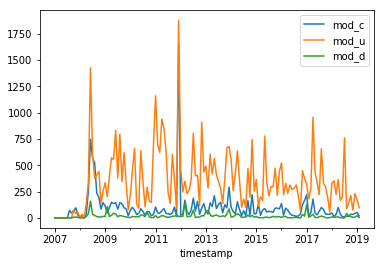

In [1]:
def modification():
    dfgb = deh.groupby(['timestamp','mod']).size().to_frame("count").reset_index()
    dfgb['mod_c'] = dfgb.apply(lambda row: row['count'] if row['mod'] == 'c' else 0, axis=1)
    dfgb['mod_d'] = dfgb.apply(lambda row: row['count'] if row['mod'] == 'd' else 0, axis=1)
    dfgb['mod_u'] = dfgb.apply(lambda row: row['count'] if row['mod'] == 'u' else 0, axis=1)
    dfgb = dfgb.groupby([pd.Grouper(key='timestamp',freq='MS')]).agg({'mod_c':'sum','mod_u':'sum','mod_d':'sum'})
    dfgb.plot()
modification()


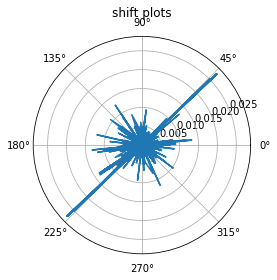

In [1]:
def shiftPlot():
    dfgb = deh.loc[deh['shifted'] == True]
    r = dfgb.apply(lambda r: np.sqrt(r['dlon']**2 + r['dlat']**2), axis=1)
    theta = dfgb.apply(lambda r: np.arctan2(r['dlat'],r['dlon']), axis=1)

    ax = plt.subplot(111, projection='polar')
    ax.plot(theta,r)
    ax.grid(True)
    ax.set_title("shift plots", va='bottom')
    plt.show()
shiftPlot()